## How correlated are lncRNAs to nearby (protein coding?) genes?

In [100]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os
from scipy.stats import sem
from sklearn.linear_model import LinearRegression



from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47796155/ipykernel_21422/4149521424.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [ ]:
covariates = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/eqtls/Brain_Caudate_basal_ganglia.v11.covariates.txt', sep='\t')
gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')
v11_expression = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/eqtls/Brain_Caudate_basal_ganglia.v11.normalized_expression.bed.gz', sep='\t')

sample_ids = v11_expression.columns[4:]
v11_expression = pd.merge(v11_expression, gencode_ids[['gene_id_v47', 'gene_type_grouped']], left_on='gene_id', right_on='gene_id_v47', how='left')
v11_expression['gene_mid'] = (v11_expression['end'] + v11_expression['start'] )/ 2

/local/scratch/klawren/slrmtmp.47796155/ipykernel_21422/2761194054.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')


In [159]:
def calculate_residual(phenotype_df, covariates_df, center=False):
    """Calculate normalized residual phenotypes"""
    # Initialize the Linear Regression model
    model = LinearRegression()

    # Convert DataFrames to NumPy arrays
    X = covariates_df.T.values
    Y = phenotype_df.T.values

    # Create an array to store the residuals
    residuals = np.zeros_like(Y)

    # Regress out the covariates for each phenotype
    for i in range(Y.shape[1]):
        y = Y[:, i]
        model.fit(X, y)
        residuals[:, i] = y - model.predict(X)

    # Center and normalize if required
    if center:
        residuals = center_normalize(residuals, axis=0)

    return residuals.T

def center_normalize(matrix, axis=0):
    """Center and normalize the matrix along the specified axis"""
    mean = np.mean(matrix, axis=axis, keepdims=True)
    std = np.std(matrix, axis=axis, keepdims=True)
    return (matrix - mean) / std

In [162]:
import tensorqtl
import torch
from tensorqtl.core import Residualizer

# adapted from tensorqtl
def calculate_residual(phenotype_df, covariates_df, center=False):
    """Calculate normalized residual phenotypes"""
    # set up residualize device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    residualizer = Residualizer(torch.tensor(covariates_df.values, dtype=torch.float32).to(device))
    phenotype_t = torch.tensor(phenotype_df.values, dtype=torch.float).to(device)
    # residualize
    phenotype_res_t = residualizer.transform(phenotype_t)  # phenotypes x samples
    # center and normalize
    if center:
        phenotype_res_t = tensorqtl.core.center_normalize(phenotype_res_t, dim=1)
    return phenotype_res_t.numpy()

In [ ]:
residualized_expression = calculate_residual(v11_expression.set_index('gene_id')[sample_ids], covariates[sample_ids].T)
v11_expression[sample_ids] = residualized_expression

In [209]:
def get_neighbor_corr(v11_expression, chr_id):
    v11_expression_chr = v11_expression[v11_expression['#chr'] == f'chr{chr_id}']
    v11_expression_chr = v11_expression_chr.set_index('gene_id')

    chr_corr = v11_expression_chr[sample_ids].T.corr(method='spearman')

    # Melt the correlations DataFrame to long format
    correlations_long = chr_corr.reset_index(names='gene_id1').melt(id_vars='gene_id1', var_name='gene_id2', value_name='correlation')
    correlations_long.columns = ['gene_id1', 'gene_id2', 'correlation']

    # Merge with genes DataFrame to get gene_mid and gene_type_grouped
    correlations_long = correlations_long.merge(v11_expression[['gene_id', 'gene_mid', 'gene_type_grouped']], left_on='gene_id1', right_on='gene_id')
    correlations_long = correlations_long.merge(v11_expression[['gene_id', 'gene_mid']], left_on='gene_id2', right_on='gene_id', suffixes=('_1', '_2'))

    # Calculate the distance between gene midpoints
    correlations_long['distance'] = np.abs(correlations_long['gene_mid_1'] - correlations_long['gene_mid_2'])
    correlations_long['log_distance'] = np.log10(correlations_long['distance'] + 1)


    # Bin the distances
    num_bins = 100  # Adjust the number of bins as needed
    correlations_long['distance_bin'] = pd.cut(correlations_long['distance'], bins=num_bins)
    correlations_long['distance_decile'] = pd.qcut(correlations_long['distance'], 10)


    # Calculate the mean correlation for each bin and gene_type_grouped
    binned_data = correlations_long.groupby(['distance_bin', 'gene_type_grouped']).agg(
        mean_correlation=('correlation', 'mean'),
        mean_distance=('distance', 'mean')
    ).reset_index()

    neighbors = correlations_long[(correlations_long['gene_id_1'] != correlations_long['gene_id_2'])].sort_values(['gene_id_1', 'distance'])
    neighbors = neighbors[neighbors['gene_id_2'].isin(gencode_ids[gencode_ids['gene_type_grouped'] == 'protien_coding']['gene_id_v47'])]
    neighbors = neighbors.drop_duplicates('gene_id_1')
    return neighbors

In [ ]:
for chr_id in tqdm(range(1, 22)):
    neighbors = get_neighbor_corr(v11_expression, 2)

NameError: name 'get_neighbor_corr' is not defined

<AxesSubplot: xlabel='gene_type_grouped', ylabel='correlation'>

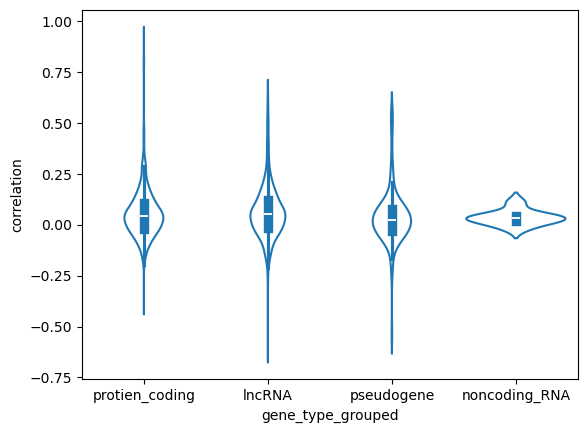

In [211]:
sns.violinplot(neighbors, y='correlation', x='gene_type_grouped', fill=False)

<AxesSubplot: xlabel='log_distance', ylabel='correlation'>

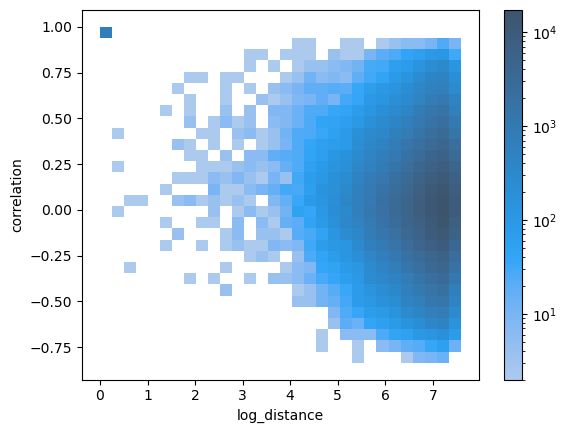

In [88]:
sns.histplot(correlations_long,x='log_distance', y='correlation', bins=30, norm=LogNorm(), vmin=None, vmax=None, cbar=True,)

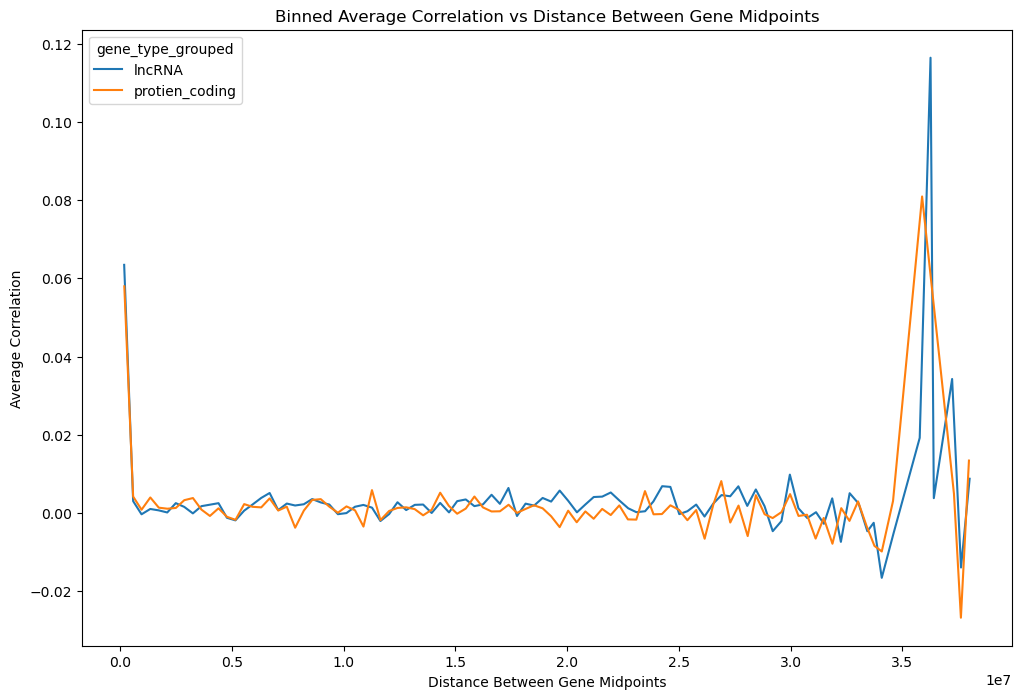

In [173]:

# Plot the binned data
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=binned_data, x='mean_distance', y='mean_correlation', hue='gene_type_grouped', hue_order = ['lncRNA', 'protien_coding'])

# Set the title and labels
plt.title('Binned Average Correlation vs Distance Between Gene Midpoints')
plt.xlabel('Distance Between Gene Midpoints')
plt.ylabel('Average Correlation')

# Show the plot
plt.show()

KeyboardInterrupt: 

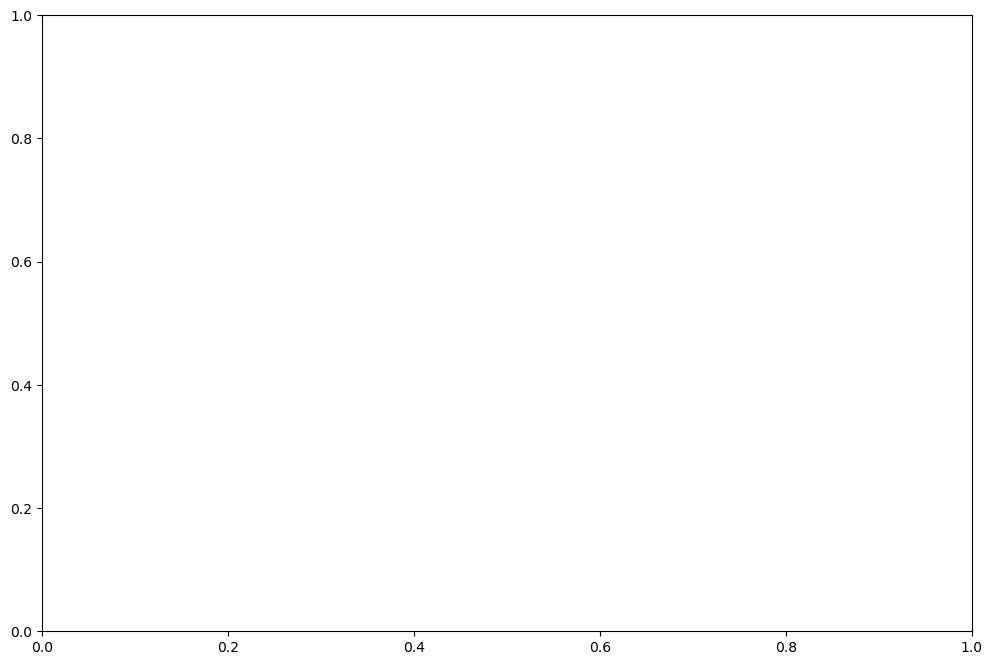

In [57]:
# Plot the data
plt.figure(figsize=(12, 8))
sns.lineplot(data=correlations_long, x='distance', y='rolling_avg_correlation', hue='gene_type_grouped')

# Set the title and labels
plt.title('Rolling Average Correlation vs Distance Between Gene Midpoints')
plt.xlabel('Distance Between Gene Midpoints')
plt.ylabel('Rolling Average Correlation')